In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Step 1: Load data
def load_data(data_path):
    try:
        data = pd.read_csv(data_path)
        print(f'Dataset loaded: {data.shape[0]} rows, {data.shape[1]} columns.')
        return data
    except FileNotFoundError:
        print(f'File was not found: {data_path}')
        return None
    
def validate_data(df):
    'Validate data structure and quality'

    validation_report = {
        'total_rows': len(df),
        'total_cols': len(df.columns),
        'missing_values': df.isnull().sum().to_dict(),
        'has_target': 'not.fully.paid' in df.columns
    }

    print('Data validation completed')
    return validation_report

In [ ]:
# Step 2: Display data information:
def display_data_info(data):
    '''Display basic information about the dataset: '''

    print('\n' + '=' * 60)
    print('Dataset Information')
    print('=' * 60)

    print(f'Shape: {data.shape}')
    print('\n Column names and data type:')
    
    for col, dtype in data.dtypes.items():
        print(f' {col}: {dtype}')
    
    print(f'\n Missing values: ')
    missing = data.isnull().sum()
    if missing.sum() == 0:
        print('No missing values')
    else:
        print(missing[missing > 0])
        

In [ ]:
# Module 2: 
def analyze_numerical_features(df):
    "Analyse statistical properties of numerical features"
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    print('\n' + '=' * 60)
    print('Numerical features analysis')
    print('=' * 60)
    stats = df[numerical_cols].describe()
    print(stats)
    return stats

def analyze_categorical_features(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    print('\n' + '=' * 60)
    print('Categorical features analysis')
    print('=' * 60)
    for col in categorical_cols:
        print(f'\n {col} (Value Counts):')
        print(df[col].value_counts())
    return categorical_cols.tolist()

def analyze_target_distribution(df):
    '''Analyze the target variable distribution'''
    target_col = 'not.fully.paid'

    if target_col in df.columns:
        print('\n' + '=' * 60)
        print('Target variable distribution')
        print('=' * 60)

        distribution = df[target_col].value_counts()
        percentage = (df[target_col].value_counts(normalize = True) * 100)
        print(f'Fully Paid (0): {distribution[0]} ({percentage[0]:.2f}%)')
        print(f'Defaulted (0): {distribution[1]} ({percentage[1]:.2f}%)')

        return distribution


def generate_eda_report(df):
    '''Generate complete EDA report:'''
    print('\n' + '=' * 60)
    print('Exploratory data Analysis report')
    print('=' * 60)

    analyze_numerical_features(df)
    analyze_categorical_features(df)
    analyze_target_distribution(df)

    print('Eda Report Generated')

def create_visualization(df, output_dir):
    '''Create and save visualization'''

    #1. Target Distribution
    plt.figure(figsize = (10,5))
    df['not.fully.paid'].value_counts().plot(kind= 'bar')
    plt.title('Loan default distribution', fontsize = 14, fontweight= 'bold')
    plt.xlabel('Not full paid (0=Paid, 1=Defaulted)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/target_distribution.png', dpi=100)
    plt.close()

    # Interest rate distribution
    plt.figure(figsize=(10,5))
    plt.hist(df['int.rate'], bins=50, edgecolor='black')
    plt.title('Interest rate distribution', fontsize= 14, fontweight= 'bold')
    plt.xlabel('Interest Rate')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/interest_rate_distribution.png', dpi= 100)
    plt.close()


    





Lending club loan default Prediction

 Step 1: Loading Data...
Dataset loaded: 9578 rows, 14 columns.

Dataset Information
Shape: (9578, 14)

 Column names and data type:
 credit.policy: int64
 purpose: object
 int.rate: float64
 installment: float64
 log.annual.inc: float64
 dti: float64
 fico: int64
 days.with.cr.line: float64
 revol.bal: int64
 revol.util: float64
 inq.last.6mths: int64
 delinq.2yrs: int64
 pub.rec: int64
 not.fully.paid: int64

 Missing values: 
No missing values
Data validation completed

Exploratory data Analysis report

Numerical features analysis
       credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0

AttributeError: module 'matplotlib.pyplot' has no attribute 'save_fig'

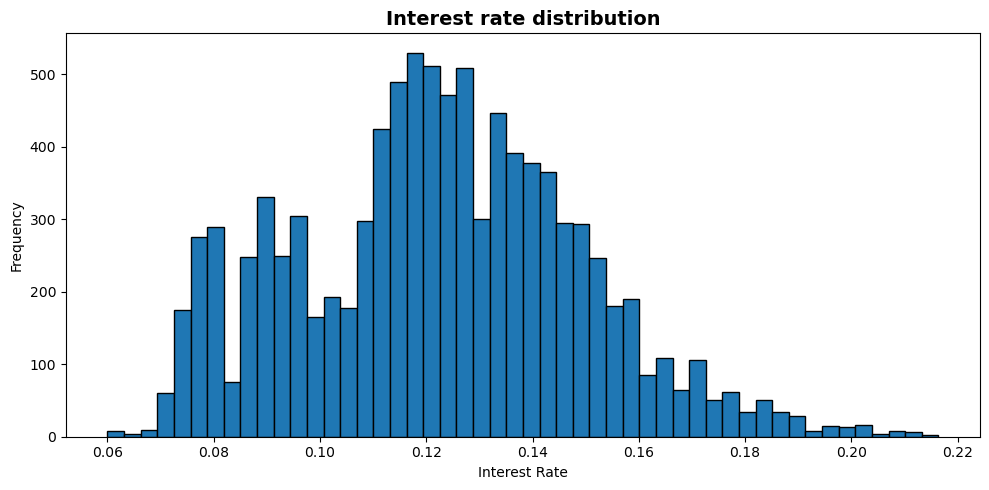

In [35]:
def main (data_path = 'loan_data.csv', output_dir = 'outputs'):

    'Execute complete pipeline:'

    print('\n' + '=' * 60)
    print('Lending club loan default Prediction')
    print('=' * 60)
    
    # Step 1: Load and validate the data:
    print('\n Step 1: Loading Data...')

    df = load_data(data_path)
    if df is None:
        print('Data set is empty')
        return
    
    # Step 2: Display data information

    display_data_info(df)
    validation = validate_data(df)

    # Step 3: Performing EDA
    generate_eda_report(df)
    create_visualization(df, output_dir)
    
    
    
    
    '''
    history = train_neural_network(
        model, 
        data_pred['X_train'],
        data_prep['y_train'],
        data_pred['X_test'],
        data_prep['y_test'],
        epochs = 50,
        batch_size = 32
    )

    # Plot training history
    # plot_training_history(history, output_dir)
    '''




if __name__ == '__main__':
    main()